In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear_marginalized.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [8]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])
PZ = [0]*nz
for i in range(nz):
    z = np.concatenate([np.linspace(-0.5, 0, 100), pz_fid[i].get_knots()[1:]])
    p = np.concatenate([np.zeros(100), pz_fid[i](pz_fid[i].get_knots()[1:])])
    PZ[i] = interpolate.InterpolatedUnivariateSpline(z, p, k = 3)
pz_fid = PZ

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
npar = 15

# Define the priors
lower = np.zeros(npar)
upper = np.zeros(npar)
lower[0:5] = np.array([0, 0.4, 0, 0.4, 0.7])
lower[5:] = np.ones(nz)*-0.5
upper[0:5] = np.array([1, 1.2, 0.1, 1.0, 1.3])
upper[5:] = np.ones(nz)*0.5
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.05, 0.05, 0.05, 0.3, 0.3])
sigmas[5:] = np.ones(nz)*0.05
S = np.eye(npar)*sigmas**2
Sinv = np.linalg.inv(S)
prior_args = [prior_mean, S, lower, upper]

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.concatenate([abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.1, 0.1, 0.05]), np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])])
dCdt = np.zeros((npar, nz, nz, len(modes)))
# Derivatives wrt cosmological parameters
for i in range(npar-nz):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])
    
# Derivatives wrt photo-z bias parameters
for i in range(nz):
    
    pzprime = [interpolate.InterpolatedUnivariateSpline(np.linspace(0, pz_fid[0].get_knots()[-1], len(pz_fid[0].get_knots())), np.zeros(len(pz_fid[0].get_knots()))) for X in range(nz)]
    pzprime[i] = pz_fid[i].derivative()
    dCdt[npar-nz+i, :, :, :] = d_power_spectrum_db(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz)), pzprime])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Sinv)

# Compute projection matrices
Fpinv = np.linalg.inv(F[5:,5:])
P = np.zeros((5, 10))
for i in range(5):
    P[i,:] = np.dot(Fpinv, F[i,5:])

# Projection arguments
projection_args = [Finv, P, theta_fiducial, fisher_errors, prior_mean, Sinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

# Now do the set up for the nuisance projected problem...
npar = 5
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Q = np.eye(npar)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
Finv = Finv[0:npar, 0:npar]
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

In [4]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [5]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [9]:
# Create the DELFI MDN object
n_components = 1

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 29s 644us/step - loss: 37.9425 - val_loss: 13.4670
Epoch 2/50
45000/45000 [==============================] - 32s 712us/step - loss: 12.3654 - val_loss: 11.5165
Epoch 3/50
45000/45000 [==============================] - 33s 726us/step - loss: 10.8212 - val_loss: 10.1120
Epoch 4/50
45000/45000 [==============================] - 30s 665us/step - loss: 9.5481 - val_loss: 8.9637
Epoch 5/50
45000/45000 [==============================] - 31s 695us/step - loss: 8.4636 - val_loss: 8.0031
Epoch 6/50
45000/45000 [==============================] - 4489s 100ms/step - loss: 7.6902 - val_loss: 7.2943
Epoch 7/50
45000/45000 [==============================] - 55s 1ms/step - loss: 7.0963 - val_loss: 6.7339
Epoch 8/50
45000/45000 [==============================] - 31s 688us/step - loss: 6.5914 - val_loss: 6.3083
Epoch 9/50
45000/45000 [============================

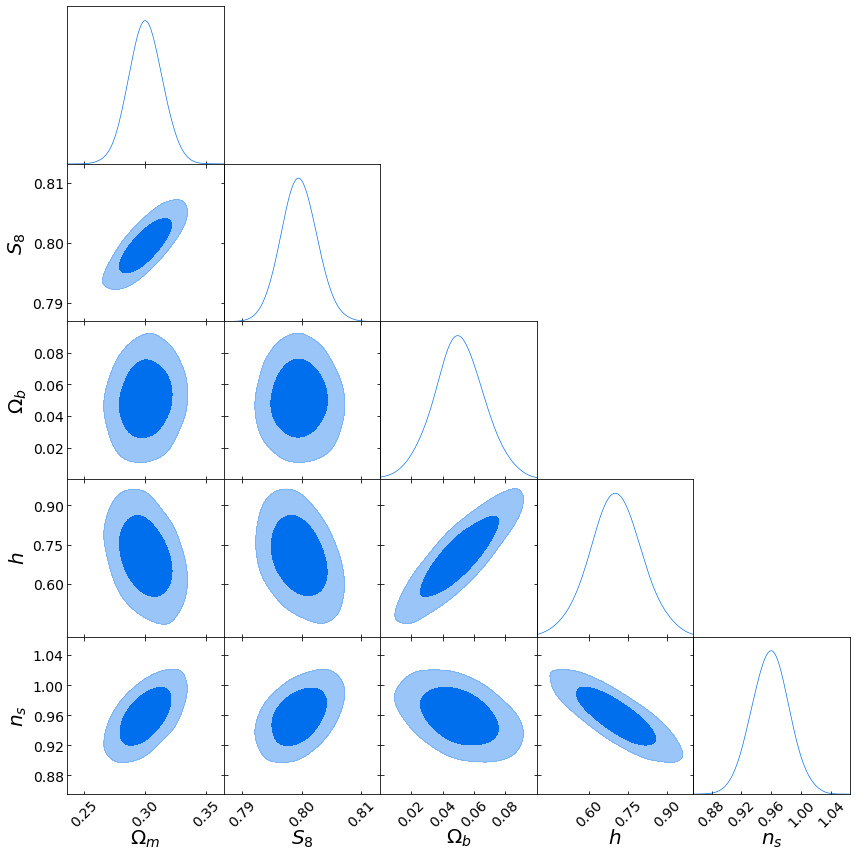

In [10]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=50)

Running initial 500 sims...


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.727415e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.870522e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.193441e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.353002e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 5.347259e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.228438e-05
  AccuracyWarning)
/usr/local

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.947102e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 5.523499e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 9.322351e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 7.457831e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 9.041377e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.984413e-05
  AccuracyWarning)
/usr/local

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 8.466764e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 9.474745e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 9.150417e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.234808e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 8.026694e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.031747e-05
  AccuracyWarning)
/usr/local

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 7.323953e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.812820e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.344133e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.405155e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.535585e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.193333e-05
  AccuracyWarning)
/usr/local

Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 0s 649us/step - loss: 21.1231 - val_loss: 22.5844
Epoch 2/100
450/450 [==============================] - 0s 642us/step - loss: 16.5509 - val_loss: 16.2577
Epoch 3/100
450/450 [==============================] - 0s 645us/step - loss: 12.6252 - val_loss: 9.9172
Epoch 4/100
450/450 [==============================] - 0s 652us/step - loss: 9.5368 - val_loss: 8.6530
Epoch 5/100
450/450 [==============================] - 0s 639us/step - loss: 7.7617 - val_loss: 7.6248
Epoch 6/100
450/450 [==============================] - 0s 625us/step - loss: 7.1660 - val_loss: 6.6694
Epoch 7/100
450/450 [==============================] - 0s 637us/step - loss: 6.4172 - val_loss: 6.4339
Epoch 8/100
450/450 [==============================] - 0s 626us/step - loss: 5.9993 - val_loss: 6.3847
Epoch 9/100
450/450 [==============================] - 0s 610us/step - loss: 5.8341 - val_loss: 6.3258
Epoch 10/100
450/

450/450 [==============================] - 0s 620us/step - loss: 4.8123 - val_loss: 5.8036
Epoch 80/100
450/450 [==============================] - 0s 628us/step - loss: 4.8134 - val_loss: 5.8007
Epoch 81/100
450/450 [==============================] - 0s 620us/step - loss: 4.8243 - val_loss: 5.8895
Epoch 82/100
450/450 [==============================] - 0s 637us/step - loss: 4.8220 - val_loss: 5.7799
Epoch 83/100
450/450 [==============================] - 0s 630us/step - loss: 4.8093 - val_loss: 5.8125
Epoch 84/100
450/450 [==============================] - 0s 635us/step - loss: 4.8529 - val_loss: 5.7887
Epoch 85/100
450/450 [==============================] - 0s 627us/step - loss: 4.8459 - val_loss: 5.7754
Epoch 86/100
450/450 [==============================] - 0s 626us/step - loss: 4.8274 - val_loss: 5.7703
Epoch 87/100
450/450 [==============================] - 0s 614us/step - loss: 4.8038 - val_loss: 5.8749
Epoch 88/100
450/450 [==============================] - 0s 640us/step - loss:

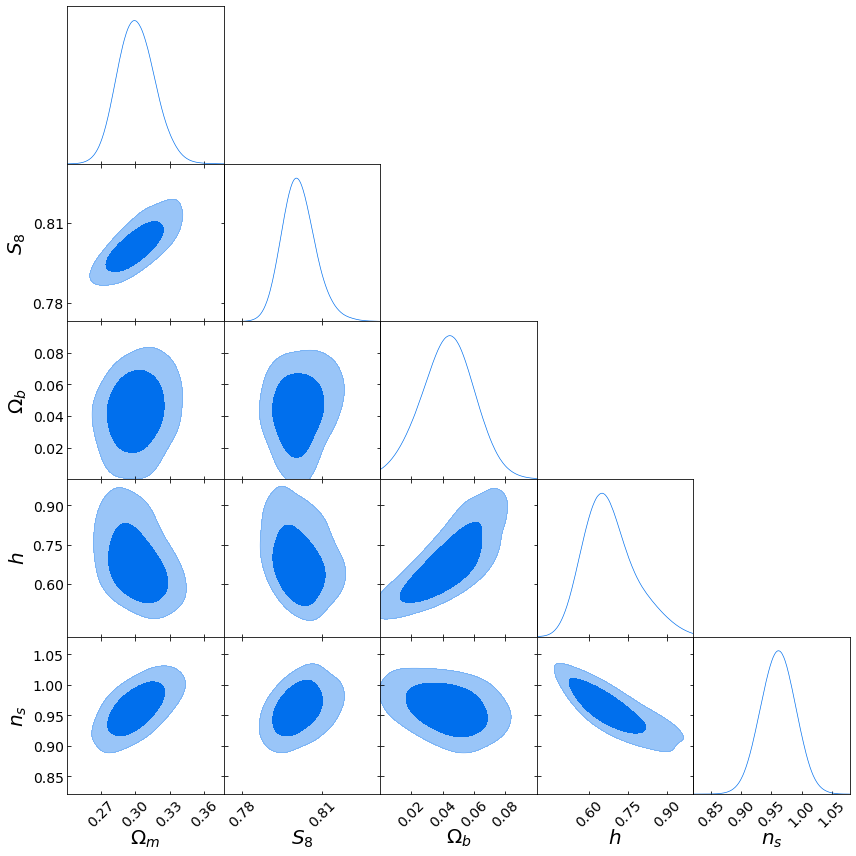

Population 1/8
Sampling proposal density...
Done.
Running 500 sims...


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 8.973740e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.227631e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.585191e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.135287e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 7.291439e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.716236e-05
  AccuracyWarning)
/usr/local

Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 599us/step - loss: 4.7679 - val_loss: 4.1682
Epoch 2/100
900/900 [==============================] - 1s 611us/step - loss: 4.7668 - val_loss: 4.2198
Epoch 3/100
900/900 [==============================] - 1s 621us/step - loss: 4.7220 - val_loss: 4.0533
Epoch 4/100
900/900 [==============================] - 1s 928us/step - loss: 4.6890 - val_loss: 4.1017
Epoch 5/100
900/900 [==============================] - 1s 739us/step - loss: 4.6937 - val_loss: 4.1594
Epoch 6/100
900/900 [==============================] - 1s 845us/step - loss: 4.6875 - val_loss: 4.1130
Epoch 7/100
900/900 [==============================] - 1s 682us/step - loss: 4.6611 - val_loss: 4.1249
Epoch 8/100
900/900 [==============================] - 1s 612us/step - loss: 4.6695 - val_loss: 4.0892
Epoch 9/100
900/900 [==============================] - 1s 623us/step - loss: 4.6626 - val_loss: 4.1203
Epoch 10/100
900/900 

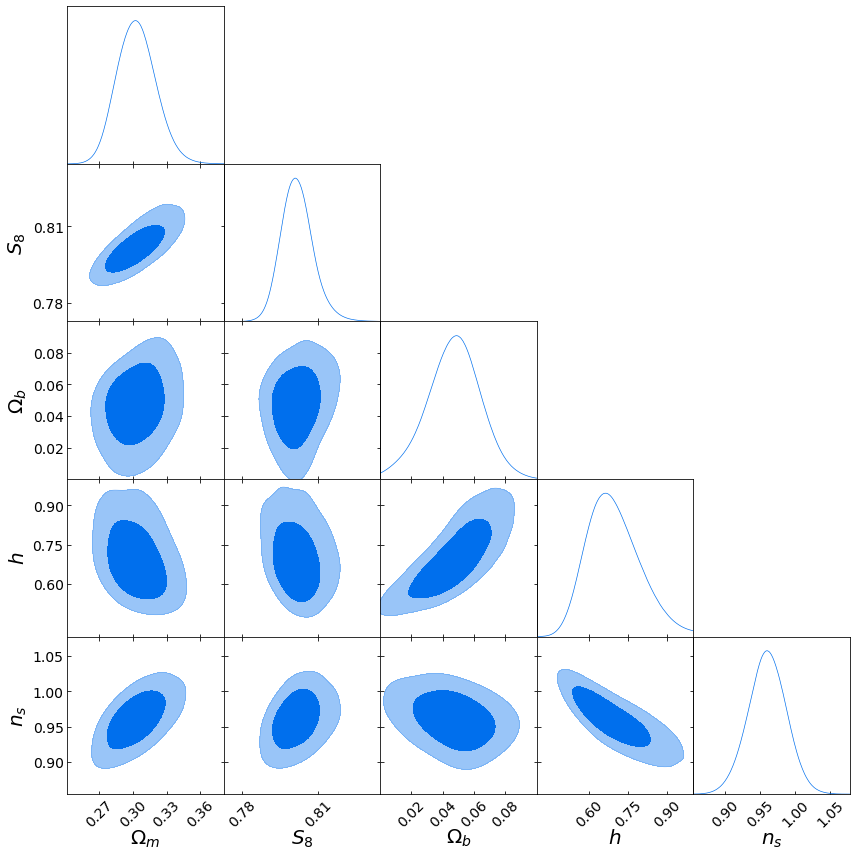

Population 2/8
Sampling proposal density...
Done.
Running 500 sims...


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.065928e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 7.045871e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.732198e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.487039e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.238969e-05
  AccuracyWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.761410e-05
  AccuracyWarning)
/usr/local

Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 1s 607us/step - loss: 4.5216 - val_loss: 4.4490
Epoch 2/100
1350/1350 [==============================] - 1s 604us/step - loss: 4.5235 - val_loss: 4.4268
Epoch 3/100
1350/1350 [==============================] - 1s 594us/step - loss: 4.5261 - val_loss: 4.4294
Epoch 4/100
1350/1350 [==============================] - 1s 600us/step - loss: 4.5403 - val_loss: 4.5154
Epoch 5/100
1350/1350 [==============================] - 1s 602us/step - loss: 4.5446 - val_loss: 4.4680
Epoch 6/100
1350/1350 [==============================] - 1s 599us/step - loss: 4.5522 - val_loss: 4.5801
Epoch 7/100
1350/1350 [==============================] - 1s 603us/step - loss: 4.5841 - val_loss: 4.4537
Epoch 8/100
1350/1350 [==============================] - 1s 602us/step - loss: 4.5242 - val_loss: 4.4298
Epoch 9/100
1350/1350 [==============================] - 1s 598us/step - loss: 4.5286 - val_loss: 4.4836
Ep

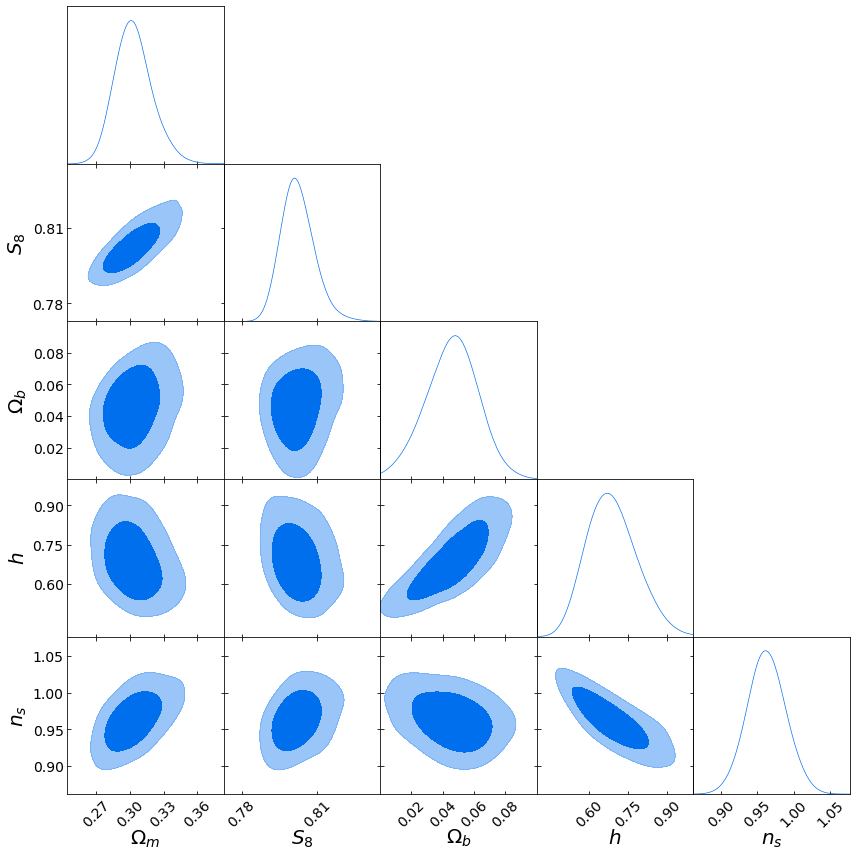

Population 3/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 1s 601us/step - loss: 4.6001 - val_loss: 4.1555
Epoch 2/100
1800/1800 [==============================] - 1s 748us/step - loss: 4.5549 - val_loss: 4.1896
Epoch 3/100
1800/1800 [==============================] - 1s 665us/step - loss: 4.5510 - val_loss: 4.1795
Epoch 4/100
1800/1800 [==============================] - 2s 971us/step - loss: 4.5220 - val_loss: 4.1230
Epoch 5/100
1800/1800 [==============================] - 1s 746us/step - loss: 4.5224 - val_loss: 4.1512
Epoch 6/100
1800/1800 [==============================] - 1s 626us/step - loss: 4.5293 - val_loss: 4.1558
Epoch 7/100
1800/1800 [==============================] - 1s 593us/step - loss: 4.5681 - val_loss: 4.1714
Epoch 8/100
1800/1800 [==============================] - 1s 588us/step - loss: 4.5471 - val_loss: 4.1126
Epoch 9/100
1800/1800 [==============

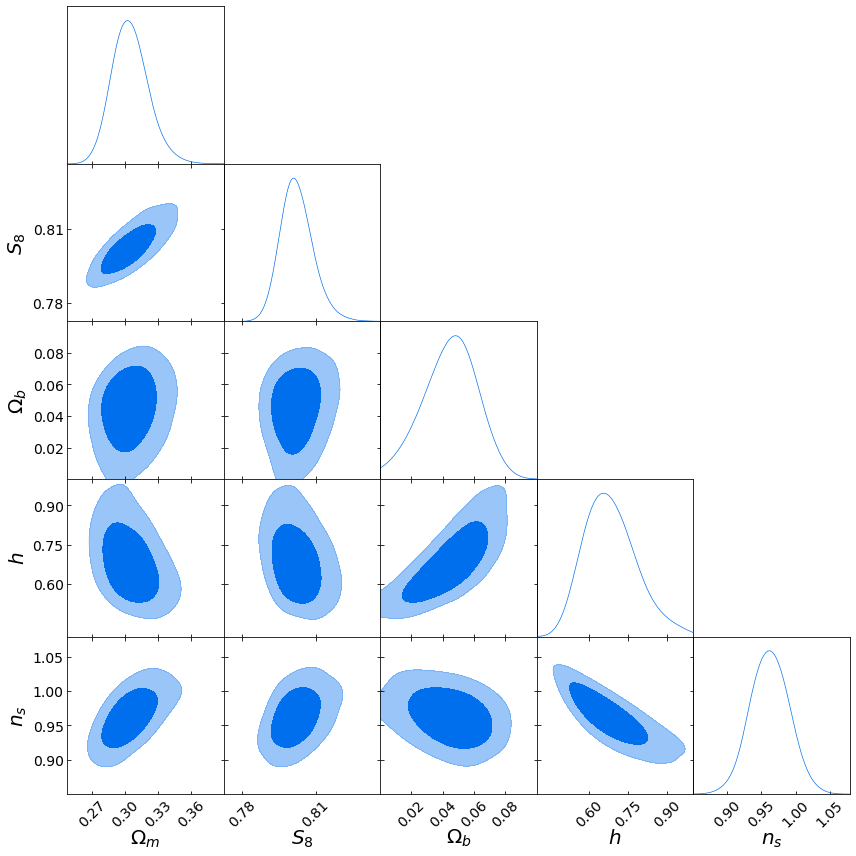

Population 4/8
Sampling proposal density...
Done.
Running 500 sims...


ValueError: array must not contain infs or NaNs

In [14]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 8

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

In [ ]:
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()